# Introdução

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import scipy.stats as stats
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Prevendo a nota da prova final de alunos

## Descrição do Dataset

Encontramos um dataset que nos pareceu interessante para tentar prever a nota depois da prova final de um aluno aleatório com base nas características da escola dele, e da nota dele antes da prova, este que está disponível em https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students. Primeiro, vamos descrever as variáveis encontradas no dataset:
* school: código representando o nome da escola;
* school_setting: o meio onde a escola se encontra (Rural, Suburban, Urban);
* school_type: se a escola é pública ou privada;
* classroom: código representando o tipo de sala de aula da escola;
* teaching_method: o método de ensino empregrado pela escola (Standard, Experimental);
* n_student: número de alunos em cada sala;
* student_id: código representando a matrícula de um aluno na sua escola;
* gender: o gênero com o qual o aluno se identifica (Female, Male);
* lunch: se o aluno faz parte do programa de distribuição de merenda;
* pretest: a nota do aluno antes da prova final;
* posttest: a nota do aluno depois da prova final;

Abaixo, as primeiras linhas do dataset:

In [2]:
raw_data = pd.read_csv("test_scores.csv",)
raw_data.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


Removemos algumas colunas que não auxiliariam a obter algum resultado, conforme as justificativas.
* school: não contribui na análise e foi retirada pela possibilidade de gerar ruído no modelo;
* classroom: não foi fornecida ou encontrada qualquer descrição para o significado dos tipos de sala de aula, então a retiramos para evitar possíveis ruídos no modelo;
* student_id: assim como a variável school, essa coluna não contribui na análise de maneira significativa mas poderia gerar muito ruído caso a mantivéssemos.

Em seguida, as primeiras linhas novamente, sem as colunas supracitadas:

In [3]:
#Pegando apenas variaveis relevantes
f_data = raw_data.loc[:,~raw_data.columns.isin({"school","classroom","student_id"})].copy()
f_data.head()

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest
0,Urban,Non-public,Standard,20.0,Female,Does not qualify,62.0,72.0
1,Urban,Non-public,Standard,20.0,Female,Does not qualify,66.0,79.0
2,Urban,Non-public,Standard,20.0,Male,Does not qualify,64.0,76.0
3,Urban,Non-public,Standard,20.0,Female,Does not qualify,61.0,77.0
4,Urban,Non-public,Standard,20.0,Male,Does not qualify,64.0,76.0


Como mencionado antes, escolhemos a variável posttest como a nossa variável target.

In [4]:
target ="posttest"
features = [col for col in f_data.columns if col != target]

As variáveis categóricas (school_setting, school_type, teaching_method, gender, lunch) do dataset estão definidas como objeto e não categoria, então fizemos essa mudança na célula abaixo.

In [5]:
#transformando variaveis nao numericas em categoricas
for col in f_data.columns:
    if (f_data[col].dtype == "object"):
        f_data[col] = f_data[col].astype('category')

# Análise Exploratória

## Variável Target
Analizamos dados sobre a distribuição das notas finais dos alunos, afim de ter uma referência das notas do nosso sample, e podermos obter resultados mais conclusivos na análise futura das variáveis feature.

Optamos por fazer isso de duas maneiras: descrevendo os dados numericamente, e fazendo dois gráficos que facilitam a visualização destes dados: um boxplot, e um histograma. 

In [6]:
f_data.posttest.describe().to_frame()

,posttest
count,2133.000000
mean,67.102203
std,13.986789
min,32.000000
25%,56.000000
50%,68.000000
75%,77.000000
max,100.000000


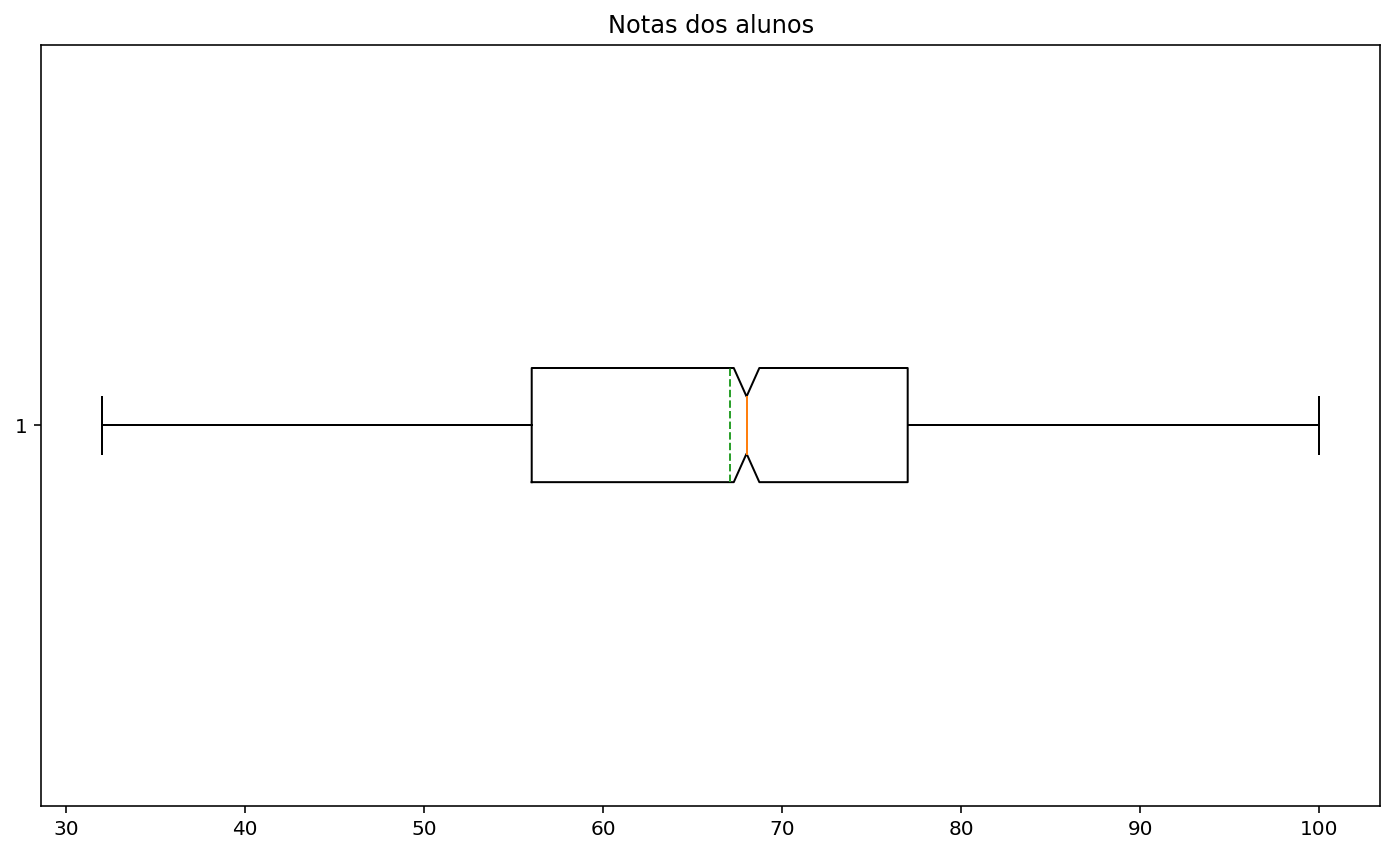

In [7]:
plt.title("Notas dos alunos")
plt.boxplot(f_data.posttest, vert = False, meanline = True, showcaps = True, showbox = True, showfliers = True, showmeans = True, notch = True)
plt.show()

Ao ver o boxplot da variável target, conseguimos tirar algumas conclusões iniciais sobre a coluna posttest com mais facilidade do que teríamos tendo só a descrição numérica. Por exemplo, vemos como é a distribuição populacional do sample conforme os quartis: há mais alunos com notas acima da média do que abaixo, o que condiz com a expectativa de que mais alunos passam de ano na escola do que não. 

Mais do que isso, temos uma comparação entre a média (linha verde pontilhada) e a mediana (linha contínua laranja) dos dados, e vemos que por mais que os valores pareçam similares numericamente, há uma distância entre elas no boxplot que sugira que há uma concentração de alunos em torno da média dos dados, por mais que a metade superior dos dados apresente maior densidade.

In [8]:
g_bins = range(30,101,5)

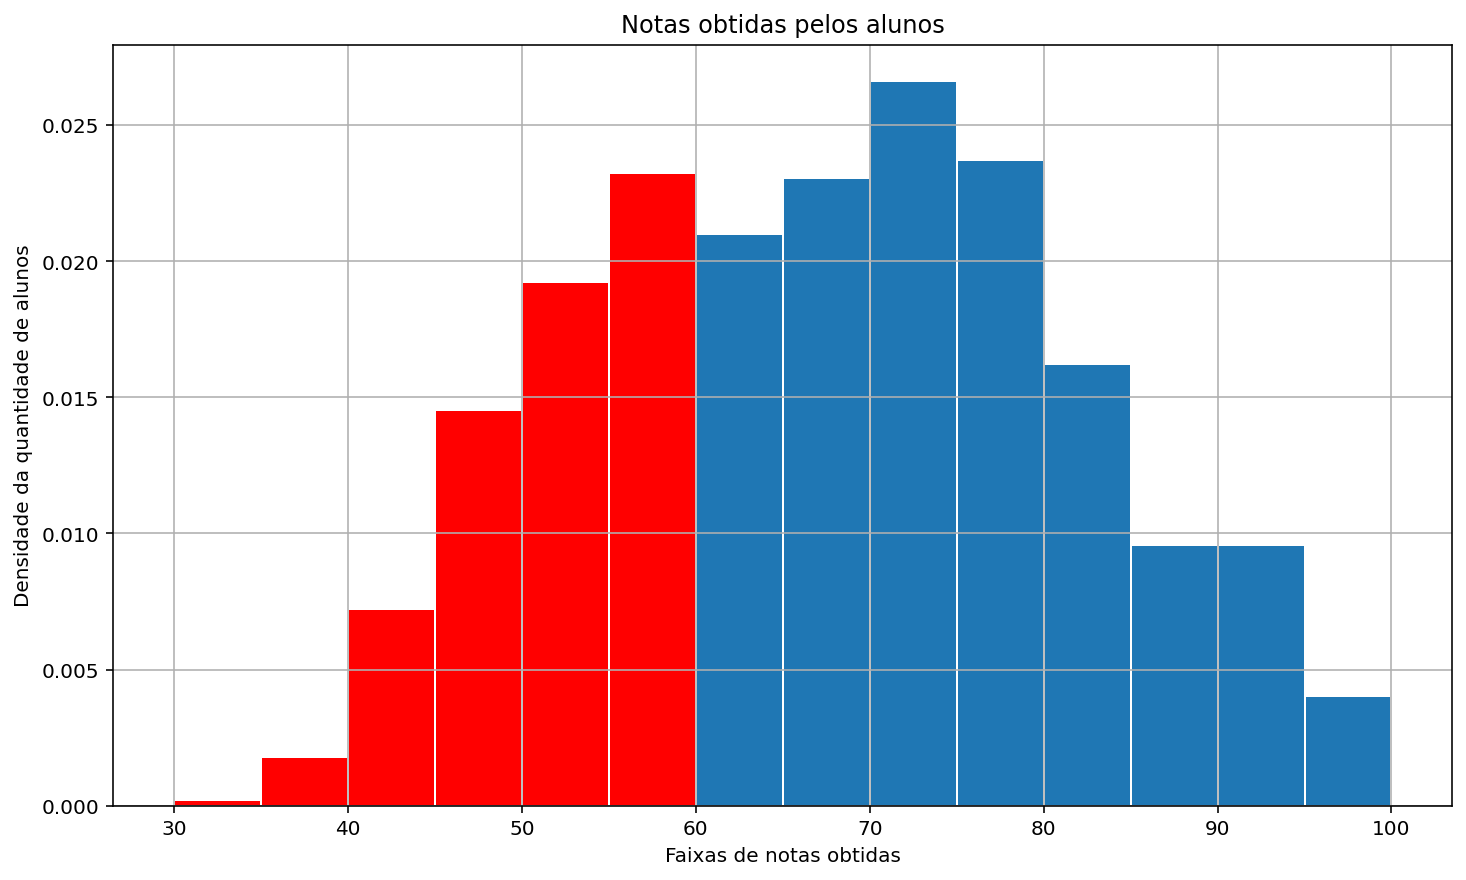

In [9]:
ax = f_data.posttest.hist(edgecolor = 'white',bins = g_bins, density = True)

for i in range(len(ax.patches)):
    if i < 6:
        ax.patches[i].set_facecolor('r')

plt.title('Notas obtidas pelos alunos')
plt.ylabel('Densidade da quantidade de alunos')
plt.xlabel('Faixas de notas obtidas')
plt.show()

Também fizemos um histograma, onde colorimos de vermelho as barras que representam alunos que tenham uma nota abaixo da média (60), e de azul as notas que significariam uma aprovação no fim do ano.

Achamos interessante fazer um boxplot e um histograma porque enquanto eles servem propósitos similares, eles dispõem a informação de maneiras que permitem diferentes conclusões a serem tiradas. O histograma nos diz onde fica a maior quantidade de alunos em um certo intervalo de notas - entre 70 e 75 pontos -, e permite avaliar se os dados estão distribuidos normalmente. O boxplot, no entanto, dá uma visualização mais geral do dataset, respondendo perguntas como: onde ficam os quartis em relação à média e a mediana? Elas são iguais? Como as notas estão distribuidas em relação à média e mediana?

## Variáveis Feature

Além de facilitar a visualização dos conteúdos destas variáveis como fizemos com a variável target, também tentamos averiguar se existe alguma correlação entre elas, ou alguma outra variável que deveríamos retirar para evitar ruídos.

Primeiro, fizemos histogramas com base nas categorias binárias das notas dos alunos, novamente marcando as notas abaixo da média em vermelho para facilitar a visualização.

['school_type', 'teaching_method', 'gender', 'lunch']


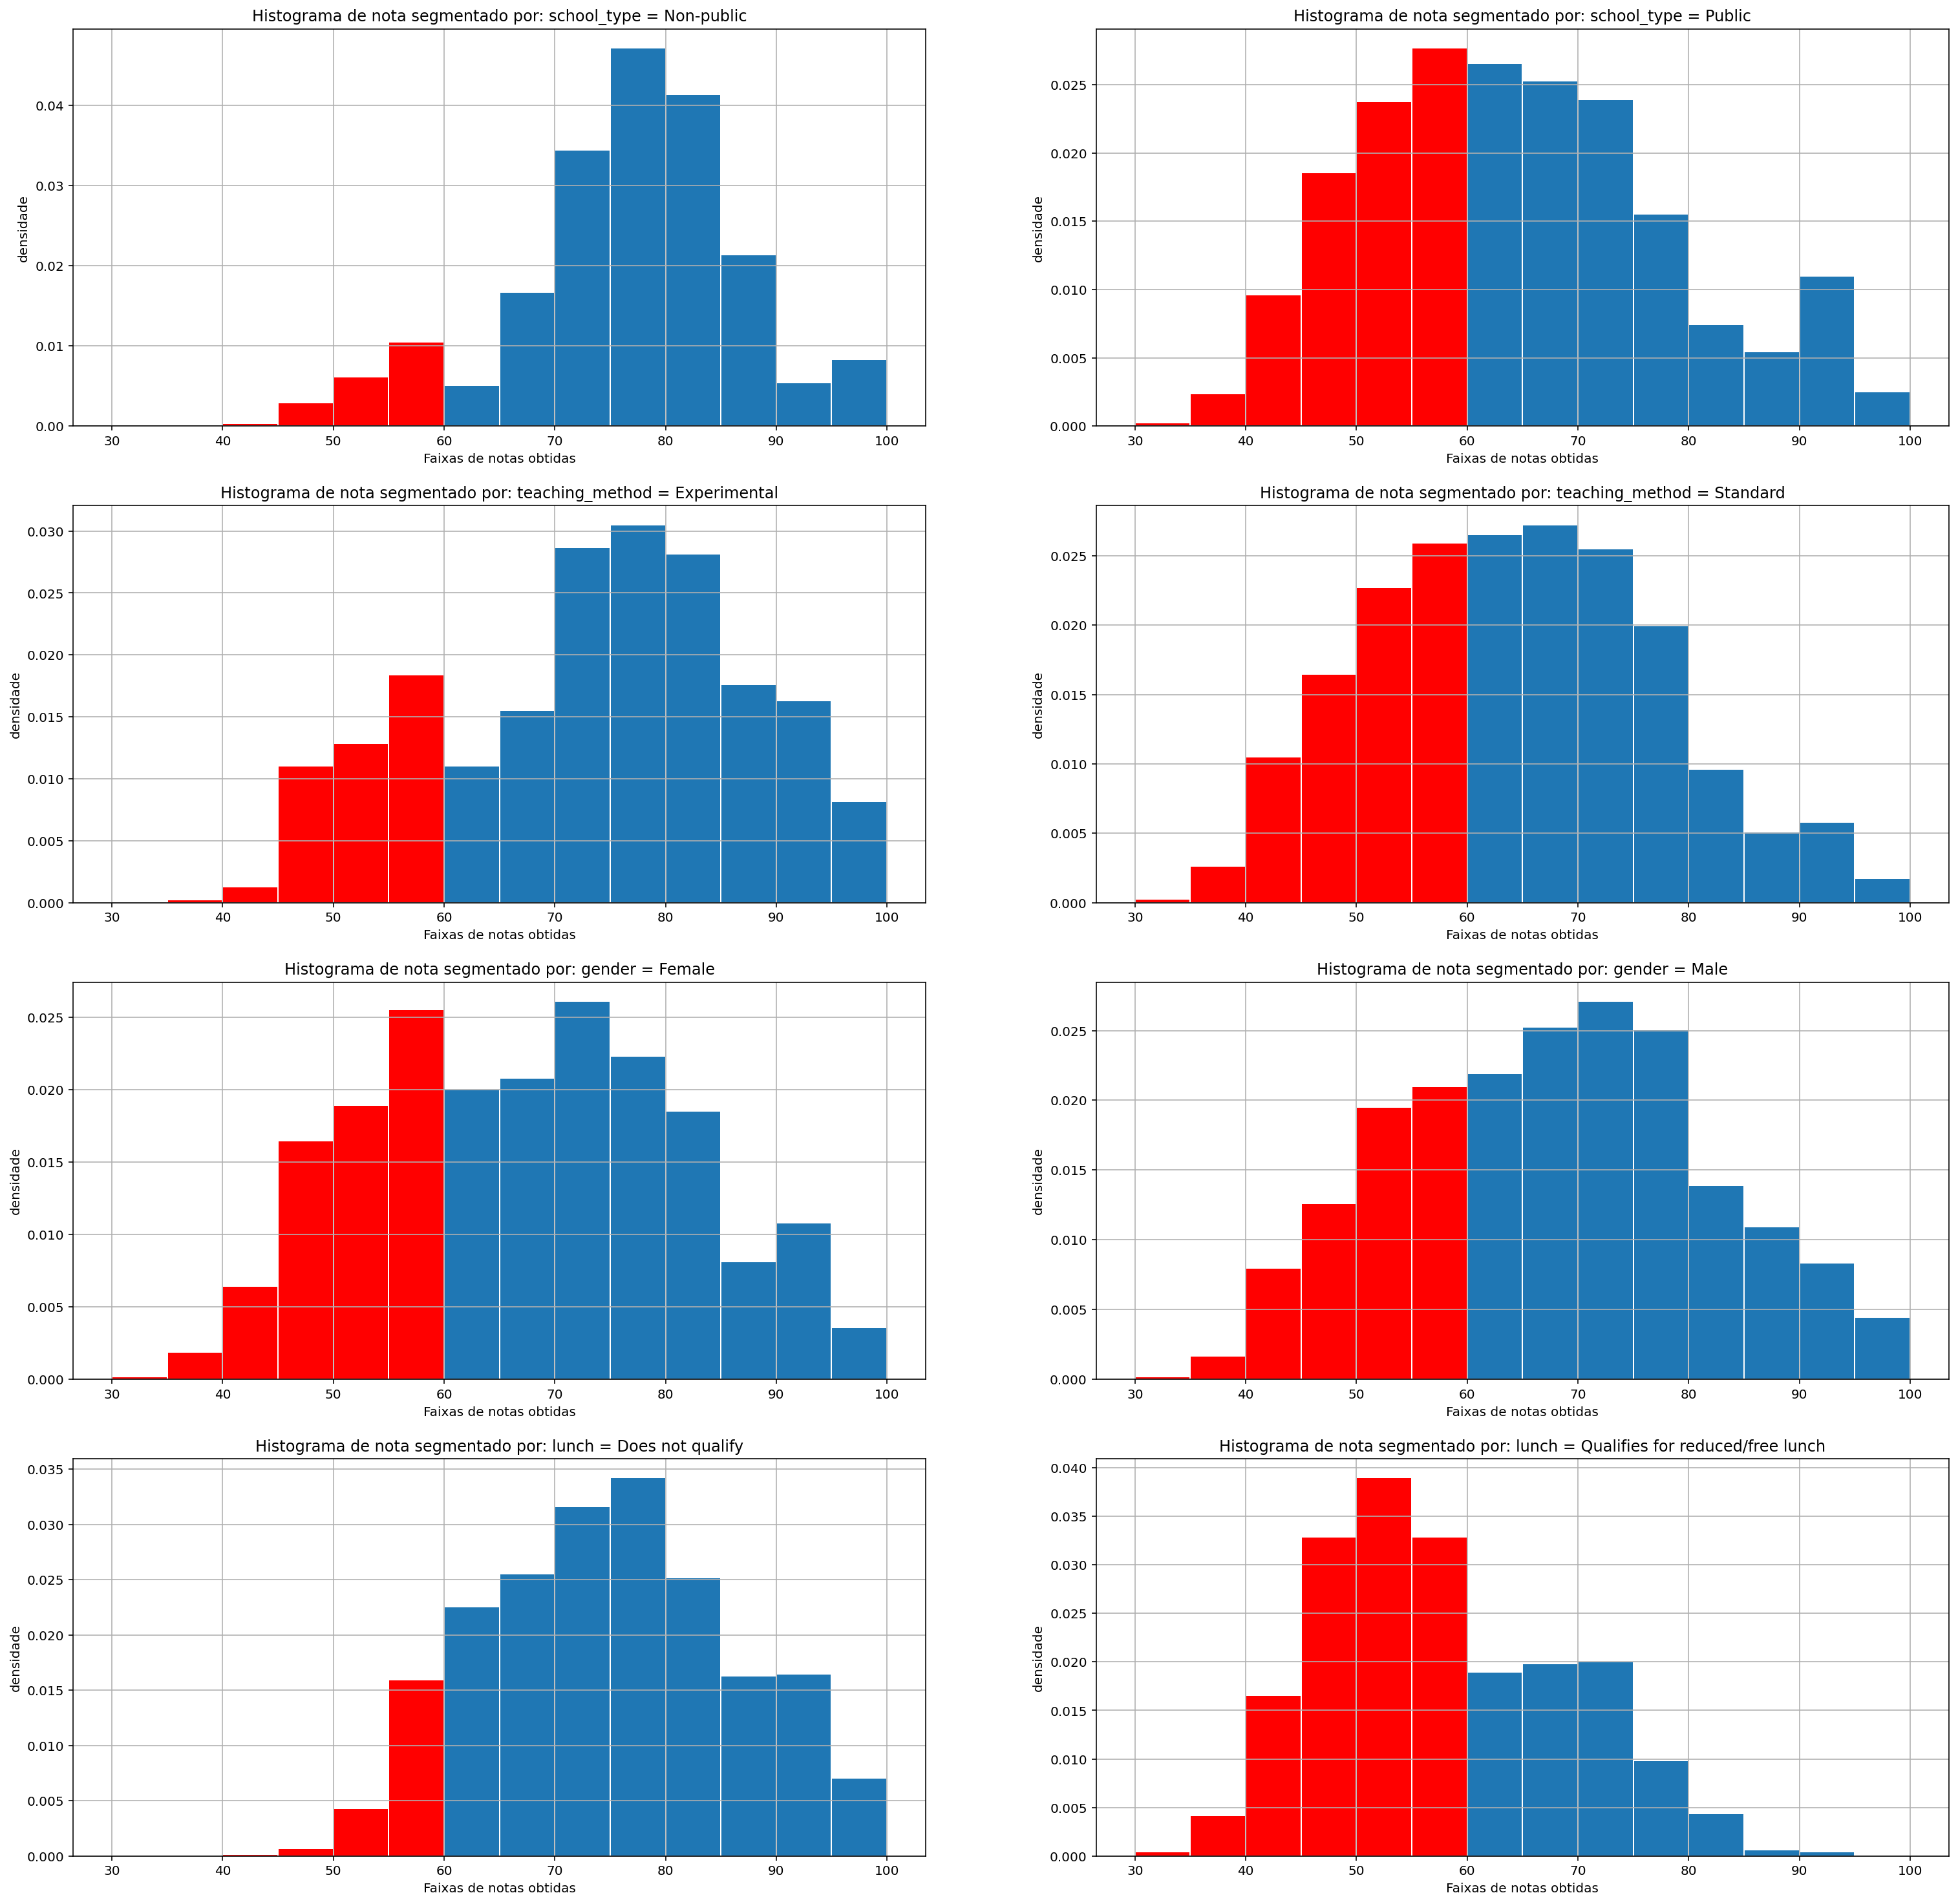

In [10]:
#Automaticamente gera Histogrmas do target segmentados pelas variaveis binarias

plt.figure(figsize =(26,26))
binary_cols = [col for col in f_data.columns if str(f_data[col].dtype) == 'category' and len(f_data[col].cat.categories)==2 ]
c = 1
print(binary_cols)

for j, col in enumerate(binary_cols):
    cats = f_data[col].cat.categories
    for i in range(len(cats)):
        plt.subplot(len(binary_cols),2,c)
        plt.title(f'Histograma de nota segmentado por: {col} = {cats[i]}')
        plt.xlabel('Faixas de notas obtidas')
        plt.ylabel('densidade')
        ax = f_data.loc[f_data[col] == cats[i],'posttest'].hist(edgecolor = 'white',bins = g_bins,density = True)
        for i in range(len(ax.patches)):
            if i < 6:
                ax.patches[i].set_facecolor('r')
        c+=1
plt.show()

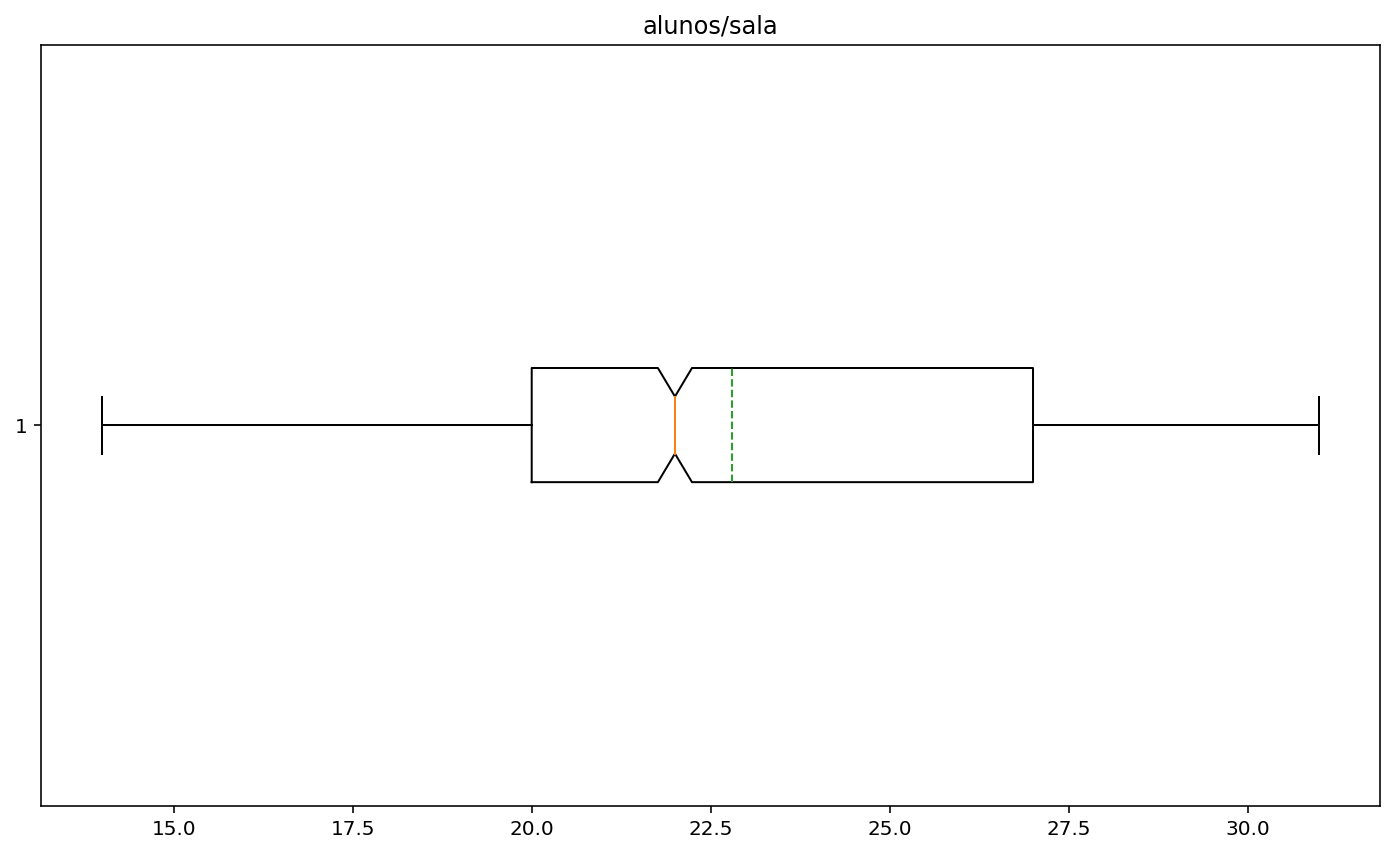

In [11]:
plt.title("alunos/sala")
plt.boxplot(f_data.n_student, vert = False, meanline = True, showcaps = True, showbox = True, showfliers = True, showmeans = True, notch = True)
plt.show()

#fazer um crosstab de alunos/sala vs nota pode ser interessante também

Alguns destes histogramas, comparando a dsitribuiçâo entre os dois valores das variáveis binárias, ressaltam um grande impacto na nota dos alunos, como por exemplo se a escola é pública ou particular. Uma quantidade quase irrelevante dos estudantes de escola particular tiram nota vermelha, enquanto uma quantidade extremamente significante dos alunos de escola pública fazem o mesmo. Isso indica que o tipo de escola onde o aluno estuda é um forte influenciador na nota.

É possível identificar uma discrepância similar ao outro caso na variável sobre o programa de distribuição de merenda, o que sugere que não é o tipo de escola que influencia mais no resultado que os estudantes apresentam, e sim a renda familiar dos alunos. Se um estudante estuda em escola pública e qualifica para o programa, há uma chance muito maior de que ele tenha nota abaixo da média do que um estudante de escola privada que não qualifique para o programa. Afim de tentar confirmar essa suspeita, tentamos traçar um gráfico conclusivo abaixo.

In [12]:
v = set(raw_data.loc[raw_data.lunch=='Qualifies for reduced/free lunch','school'].value_counts().to_frame().index.to_series())
p = set(raw_data.loc[raw_data.school_type=='Public','school'].value_counts().to_frame().index.to_series())
print(len(v))
print(len(v.intersection(p)))

#editar isso amanhã pra fazer o gráfico

20
13


gráfico almoço x escola pub/priv

In [13]:
pd.crosstab(f_data.school_type,f_data.lunch,normalize='index').round(3)*100

lunch,Does not qualify,Qualifies for reduced/free lunch
school_type,,
Non-public,71.3,28.7
Public,52.0,48.0


In [14]:
pd.crosstab(f_data.school_type,f_data.teaching_method,normalize='columns').round(3)*100

teaching_method,Experimental,Standard
school_type,,
Non-public,34.9,20.8
Public,65.1,79.2


In [15]:
binned_grades = pd.cut(f_data.posttest, bins=g_bins)
(pd.crosstab(binned_grades,f_data.school_setting,normalize="columns")*100).round(1)

school_setting,Rural,Suburban,Urban
posttest,,,
"(30, 35]",0.0,0.0,0.3
"(35, 40]",3.1,0.0,1.2
"(40, 45]",8.0,0.0,5.8
"(45, 50]",3.9,0.6,15.5
"(50, 55]",9.2,2.5,16.9
"(55, 60]",15.1,6.0,13.7
"(60, 65]",8.0,9.1,12.3
"(65, 70]",15.5,14.6,9.6
"(70, 75]",18.8,16.2,6.1


In [16]:
(pd.crosstab(binned_grades,pd.cut(f_data.n_student,bins=range(10,36,5)),normalize="columns")*100).round(1)

n_student,"(10, 15]","(15, 20]","(20, 25]","(25, 30]","(30, 35]"
posttest,,,,,
"(30, 35]",0.0,0.0,0.0,0.5,0.0
"(35, 40]",0.0,0.0,2.1,1.4,0.0
"(40, 45]",0.0,0.0,7.0,5.5,0.0
"(45, 50]",0.0,1.1,7.8,15.7,0.0
"(50, 55]",0.0,5.7,8.5,17.1,41.9
"(55, 60]",0.0,8.8,9.2,16.9,51.6
"(60, 65]",1.4,5.7,7.6,20.1,6.5
"(65, 70]",16.4,10.3,15.1,11.6,0.0
"(70, 75]",26.0,20.0,11.1,6.2,0.0


In [17]:
#Automaticamente transforma Variaveis categorigas e binarias em valores que podem ser usados pelo
data = f_data.copy()
categories = dict()
for col in data.columns:
    if str(data[col].dtype) != "category":
        continue
    if len(cats := data[col].cat.categories) == 2:
        categories[col] = {cats[0]:-1,cats[1]:1}
    else:
        categories[col] = {cats[i]:i for i in range(len(cats))}
    data[col] = data[col].apply(lambda x: categories[col][x])
print(categories)
data.head()

{'school_setting': {'Rural': 0, 'Suburban': 1, 'Urban': 2}, 'school_type': {'Non-public': -1, 'Public': 1}, 'teaching_method': {'Experimental': -1, 'Standard': 1}, 'gender': {'Female': -1, 'Male': 1}, 'lunch': {'Does not qualify': -1, 'Qualifies for reduced/free lunch': 1}}


,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest
0,2,-1,1,20.0,-1,-1,62.0,72.0
1,2,-1,1,20.0,-1,-1,66.0,79.0
2,2,-1,1,20.0,1,-1,64.0,76.0
3,2,-1,1,20.0,-1,-1,61.0,77.0
4,2,-1,1,20.0,1,-1,64.0,76.0


# Aplicando modelos de Tomada de Decisão

A partir da análise exploratória feita, temos agora uma ideia muito mais consolidada dos fatores que podem influenciar a nota dos alunos, então partimos para testar alguns modelos de predição. Escolhemos os modelos Random Forest e Decision Tree para isso.

In [18]:
r_data = data.sample(frac=1, random_state=13077, ignore_index=True).drop(columns=[])
# Separa o df em train e test, com teste de 1/3
train, test =(r_data.iloc[:1000].copy(), r_data.iloc[1000:].copy())
tree = DecisionTreeRegressor()
forest = RandomForestRegressor()
tree.fit(train.drop(columns=["posttest"]),train.posttest)
forest.fit(train.drop(columns=["posttest"]),train.posttest)
test["prediction_tree"] = tree.predict(test.drop(columns=["posttest"]))
test["prediction_forest"] = forest.predict(test.drop(columns=["posttest","prediction_tree"]))

test.head()

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest,prediction_tree,prediction_forest
1000,1,1,1,27.0,1,1,52.0,65.0,62.75,62.682964
1001,1,1,-1,23.0,-1,-1,79.0,94.0,92.50,93.060000
1002,0,1,1,19.0,-1,-1,62.0,73.0,73.00,72.700000
1003,2,1,-1,24.0,1,-1,53.0,71.0,70.00,69.947333
1004,2,1,1,25.0,-1,1,35.0,52.0,53.00,50.825000


## Testando a performance dos modelos

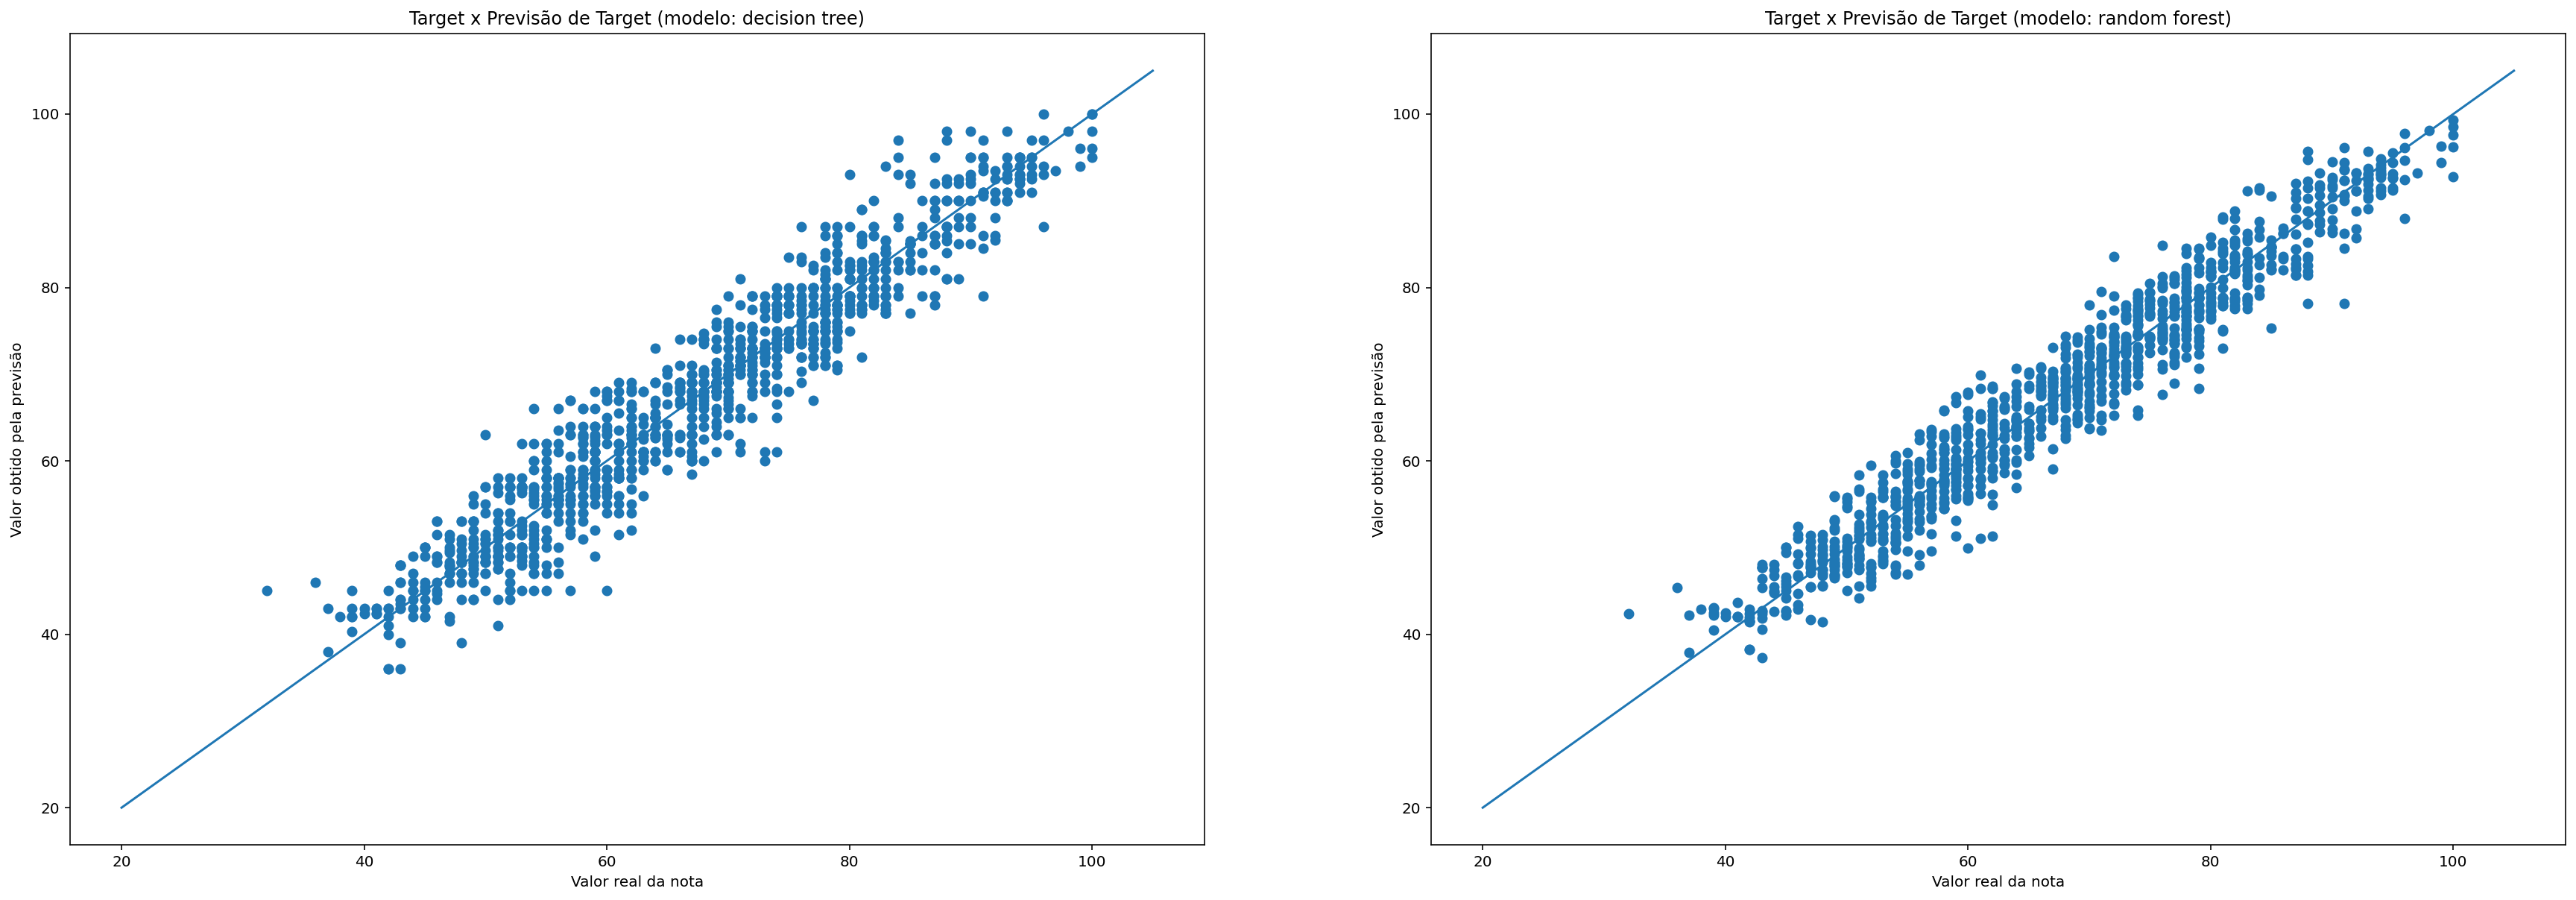

In [19]:
plt.figure(figsize=(30,10))
for title,col,i in zip(["(modelo: decision tree)","(modelo: random forest)"],[test.prediction_tree,test.prediction_forest],range(2)):
    plt.subplot(121+i)
    plt.title(f'Target x Previsão de Target {title}')
    plt.xlabel('Valor real da nota')
    plt.ylabel('Valor obtido pela previsão')
    plt.scatter(test.posttest,col)
    plt.plot([20,105],[20,105])


COMENTAR SOBRE A SIMILARIDADE VISUAL DOS GRÁFICOS E O QUE PODE INDICAR

## Obtendo o valor de R² para a previsão obtida

### R² da decision tree

In [20]:
tree.score(test.loc[:,features],test.loc[:,target])

0.9134933843415713

### R² do Random Forest

In [21]:
forest.score(test.loc[:, features], test.loc[:, target])

0.9403157327451139

In [22]:
cross_val_score(tree,test.loc[:,features],test.loc[:,target])

array([0.91777117, 0.91431361, 0.92603862, 0.91119254, 0.90395755])

In [23]:
cross_validate(tree,data.loc[:,features],data.loc[:,target],scoring=['r2','neg_root_mean_squared_error'])

{'fit_time': array([0.00821757, 0.00506973, 0.00646234, 0.07135606, 0.00741458]),
 'score_time': array([0.00253987, 0.00245166, 0.00321269, 0.00327039, 0.00245094]),
 'test_r2': array([0.63137799, 0.84794665, 0.89316671, 0.33154367, 0.8204493 ]),
 'test_neg_root_mean_squared_error': array([-4.76801424, -4.93598337, -5.1063708 , -9.19714045, -5.52093115])}

In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test.loc[:,target], test.loc[:,"prediction_tree"]))
rmse

4.07173527449084